In [2]:
import os
from os import path
import textwrap
from datetime import datetime, timedelta, date
import pytz

from igraph import *

import seaborn as sns
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.colors as clr

In [3]:
title = "WKU"
base_folder = "./simulations/wku23"
sim_id = 165
sim_tz = "Asia/Shanghai"
time0 = 'Nov 20 2023 9:00AM'
time1 = 'Dec 4 2023 12:00PM'
time_step_min = 30
use_new_id_schema = True   

In [4]:
# Configuration

# Option colors:
# https://matplotlib.org/3.1.0/gallery/color/named_colors.html
option_color = {0: clr.to_hex("cornflowerblue"),
                1: clr.to_hex("darkorange"),
                2: clr.to_hex("darkorchid"),
                3: clr.to_hex("darkgrey"),
                4: clr.to_hex("mediumseagreen")
               } 

data_folder = path.join(base_folder, "data")
output_root = path.join(base_folder, "output")
output_folder = path.join(output_root, "behaviors")
if not path.exists(output_folder):
    os.makedirs(output_folder)

# Print warning messages to the console when parsing data
print_data_warnings = True

save_images = True
image_format = "png"

# Time delta for plots in seconds
time_delta_sec = 60 * (60 * 24)

# https://howchoo.com/g/ywi5m2vkodk/working-with-datetime-objects-and-timezones-in-python
# https://itnext.io/working-with-timezone-and-python-using-pytz-library-4931e61e5152
timezone = pytz.timezone(sim_tz)

if time0 and time1:
    obs_date0 = timezone.localize(datetime.strptime(time0, '%b %d %Y %I:%M%p'))
    obs_date1 = timezone.localize(datetime.strptime(time1, '%b %d %Y %I:%M%p'))
else:
    obs_date0 = None
    obs_date1 = None

In [5]:
def get_modifiers_list(events):
    modifiers = events[(events["type"] == "modifier")]
    return modifiers

def get_score_events(events):
    scores = events[(events["type"] == "score")]
    return scores

def get_modifier_count(events, name):
    return len(events[(events["modifier"] == name)])    

def get_message_counts(events):
    msg1 = len(events[(events["modifier"] == "https://www.wkuoo23-simulation.info/psa-message-1")])
    msg2 = len(events[(events["modifier"] == "https://www.wkuoo23-simulation.info/psa-message-2")])
    return {"message_suggest_quarantine":msg1, "message_demand_quarantine":msg2}

def get_behavior_counts(events):
    nq = len(events[(events["inf"] == "quarantine")])
    nnq = len(events[(events["inf"] == "noQuarantine")])
    return {"quarantine_choice_yes":nq, "quarantine_choice_no":nnq}
    
# https://stackoverflow.com/a/48938464
def hour_rounder(t):
    # Rounds to nearest hour by adding a timedelta hour if minute >= 30
    return (t.replace(second=0, microsecond=0, minute=0, hour=t.hour)
               +timedelta(hours=t.minute//30))

In [6]:
# Load participants and histories

user_survey = pd.read_csv(path.join(data_folder, "survey.csv")) 
question1 = "Public health officials should have the power to order people into quarantine during COVID-19 outbreaks"
question2 = "If someone is given a quarantine order by a public health official, they should follow it no matter what else is going on in their life at work or home"
question3 = "If I go into quarantine, my family, friends, and community will be protected from getting COVID-19"

all_users = pd.read_csv(path.join(data_folder, "participants.csv")) 
all_events = pd.read_csv(path.join(data_folder, "histories.csv"))

users = all_users[all_users["sim_id"] == sim_id]

events = all_events[all_events["sim_id"] == sim_id]
events.fillna({'contact_length':0, 'peer_id':-1}, inplace=True)
events["event_start"] = events["time"] - events["contact_length"]/1000
events["event_start"] = events["event_start"].astype(int)

p2pToSim = pd.Series(users.sim_id.values, index=users.p2p_id).to_dict()
p2pToId = pd.Series(users.id.values, index=users.p2p_id).to_dict()
idTop2p = pd.Series(users.p2p_id.values, index=users.id).to_dict()

user_ids = []
uId2Id = {}
for rid, id in zip(list(users.random_id.values), list(users.id.values)):
    uid = str(rid).rjust(4, '0')
    user_ids.append(uid)
    uId2Id[uid] = id

user_index = {}
index_user = {}
idx = 0
for kid in idTop2p:
    user_index[kid] = idx
    index_user[idx] = kid
    idx += 1

# These should return the same value
print(len(users))
print(len(idTop2p))    
print(len(p2pToId))
print(len(user_index))

/var/folders/4g/z3rj5j_j781_8ckvkcy7p4840000gp/T/ipykernel_12623/754287964.py:9: DtypeWarning: Columns (6,7,8,13) have mixed types. Specify dtype option on import or set low_memory=False.
  all_events = pd.read_csv(path.join(data_folder, "histories.csv"))


794
794
794
794


In [7]:
# Round min and max times to the hour
min_time = min(events['time'])
max_time = max(events['time'])
first_date = hour_rounder(datetime.fromtimestamp(min_time, tz=timezone))
last_date = hour_rounder(datetime.fromtimestamp(max_time, tz=timezone))
min_time = datetime.timestamp(first_date)
max_time = datetime.timestamp(last_date)

print("First event:", first_date)
print("Last event :", last_date)

if time0 and time1:
    print("Start time:", datetime.strptime(time0, '%b %d %Y %I:%M%p'))
    print("End time:", datetime.strptime(time1, '%b %d %Y %I:%M%p'))

print(first_date.tzinfo)

First event: 2023-11-19 15:00:00+08:00
Last event : 2023-12-05 16:00:00+08:00
Start time: 2023-11-20 09:00:00
End time: 2023-12-04 12:00:00
Asia/Shanghai


## QUARANTINE/MASKING CHOICE OVER TIME

In [8]:
# Behaviors over time

frame = 0

if obs_date0 and obs_date1:
    tmin = datetime.timestamp(obs_date0)
    tmax = datetime.timestamp(obs_date1)
    print(obs_date0, obs_date1)
else:
    tmin = min_time
    tmax = max_time

series_quarantine_yes = []
series_quarantine_no = []
series_wearing_mask = []
series_medicine = []
series_quarantine_ratio = []
series_message_suggest = []
series_message_demand = []

time_labels = []
time_ticks = []
time_index = []

t = tmin
print("FRAME", end =" ") 
while t <= tmax:
    t0 = t
    t += time_delta_sec
    td = datetime.fromtimestamp(t0, tz=timezone)

    # We want to include events that ocurred between t0 and t
    condition = (t0 < events['time']) & (events['time'] <= t)

    tevents = events[condition]
    mevents = get_modifiers_list(tevents)
    score_events = get_score_events(tevents)

    mask_count = get_modifier_count(mevents, "Wearing Mask")
    med_count = get_modifier_count(mevents, "Wearing Mask")
    
    messages = get_message_counts(mevents)
    behaviors = get_behavior_counts(score_events)

    time_index.append(frame)
    time_labels.append(td.strftime('%b %d %-I:%M %p'))
    time_ticks.append(frame)

    series_wearing_mask.append(mask_count)
    
    series_message_suggest.append(messages['message_suggest_quarantine'])
    series_message_demand.append(messages['message_demand_quarantine'])

    q_yes = behaviors['quarantine_choice_yes']
    q_no = behaviors['quarantine_choice_no']
    q_total = q_yes + q_no
    
    series_quarantine_yes.append(q_yes)
    series_quarantine_no.append(q_no)

    series_quarantine_ratio.append(100 * float(q_yes) / q_total)

    frame += 1

print("\nDONE")

2023-11-20 09:00:00+08:00 2023-12-04 12:00:00+08:00
FRAME 
DONE


In [12]:
# Quarantine yes/no plots

fig, ax = plt.subplots(figsize=(8,6), facecolor="white")
# plt.xlabel("Time", labelpad=15, fontsize=15)
plt.ylabel("Participants", labelpad=15, fontsize=15)
plt.ylim(0, 250)
ax.plot(time_index, series_quarantine_yes, label="Quarantine YES", color=option_color[0], lw=2)
plt.xticks(time_ticks, time_labels, rotation=45, horizontalalignment="right")
plt.legend(loc='upper right')
plt.tight_layout()
if save_images:
    img_fn = "quarantine_yes_count." + image_format
    fig.savefig(os.path.join(output_folder, img_fn))
    plt.close('all')

fig, ax = plt.subplots(figsize=(8,6), facecolor="white")
plt.ylabel("Participants", labelpad=15, fontsize=15)
plt.ylim(0, 250)
ax.plot(time_index, series_quarantine_no, label="Quarantine NO", color=option_color[0], lw=2)
plt.xticks(time_ticks, time_labels, rotation=45, horizontalalignment="right")
plt.legend(loc='upper right')
plt.tight_layout()
if save_images:
    img_fn = "quarantine_no_count." + image_format
    fig.savefig(os.path.join(output_folder, img_fn))
    plt.close('all')

# Quarantine yes/no ratio plot
fig, ax = plt.subplots(figsize=(8,6), facecolor="white")     
# plt.xlabel("Time", labelpad=15, fontsize=15)
plt.ylabel("Percentage", labelpad=15, fontsize=15)
ax.plot(time_index, series_quarantine_ratio, label="Yes to no ratio", color=option_color[3], lw=2)
plt.xticks(time_ticks, time_labels, rotation=45, horizontalalignment="right")
plt.legend(loc='upper right')
plt.tight_layout()
if save_images:
    img_fn = "quarantine_choice_ratio." + image_format
    fig.savefig(os.path.join(output_folder, img_fn))
    plt.close('all')

# Quarantine message received plot
fig, ax = plt.subplots(figsize=(8,6), facecolor="white")     
# plt.xlabel("Time", labelpad=15, fontsize=15)
plt.ylabel("Participants", labelpad=15, fontsize=15)
ax.plot(time_index, series_message_suggest, label="Suggested to quarantine", color=option_color[0], lw=2)
ax.plot(time_index, series_message_demand, label="Mandated to quarantine", color=option_color[1], lw=2)
plt.legend(loc='upper right')
plt.tight_layout()
if save_images:
    img_fn = "quarantine_message_counts." + image_format
    fig.savefig(os.path.join(output_folder, img_fn))
    plt.close('all')

# Mask wearing
fig, ax = plt.subplots(figsize=(8,6), facecolor="white")     
# plt.xlabel("Time", labelpad=15, fontsize=15)
plt.ylabel("Count", labelpad=15, fontsize=15)
plt.ylim(0, 250)
ax.plot(time_index, series_wearing_mask, label="Wearing mask", color=option_color[0], lw=2)
plt.xticks(time_ticks, time_labels, rotation=45, horizontalalignment="right")
plt.legend(loc='upper right')
plt.tight_layout()
if save_images:
    img_fn = "mask_wearing_counts." + image_format
    fig.savefig(os.path.join(output_folder, img_fn))
    plt.close('all')

## RESPONSES TO PRE-SIMULATION SURVEY

In [87]:
counts, bin_edges = np.histogram(user_survey["question1"], bins=5)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Calculate bin centers

tick_labels = ['Strongly disagree', 'Somewhat disagree', 'Neither agree nor disagree', 'Somewhat agree', 'Strongly agree']

# Calculate bar width (as a fraction of bin width)
bar_width = (bin_edges[1] - bin_edges[0]) * 0.8  # 80% of the bin width

centers = np.arange(1, 6, 1)
bin_edges = np.concatenate((centers - 0.5, [centers[-1] + 0.5]))

plt.figure(figsize=(8, 6))
plt.title("\n".join(textwrap.wrap(question1, width=80)))
plt.hist(user_survey["question1"], bins=bin_edges, align = 'mid', rwidth=0.7, color=option_color[4])
plt.xticks(centers, tick_labels, rotation=45, ha='right')
plt.tight_layout()
if save_images:
    img_fn = "question1_hist." + image_format
    plt.savefig(os.path.join(output_folder, img_fn))
    plt.close('all')
    
plt.figure(figsize=(8, 6))
plt.title("\n".join(textwrap.wrap(question2, width=80)))
plt.hist(user_survey["question2"], bins=bin_edges, align = 'mid', rwidth=0.7, color=option_color[4])
plt.xticks(centers, tick_labels, rotation=45, ha='right')
plt.tight_layout()
if save_images:
    img_fn = "question2_hist." + image_format
    plt.savefig(os.path.join(output_folder, img_fn))
    plt.close('all')
    
plt.figure(figsize=(8, 6))
plt.title("\n".join(textwrap.wrap(question3, width=80)))
plt.hist(user_survey["question3"], bins=bin_edges, align = 'mid', rwidth=0.7, color=option_color[4])
plt.xticks(centers, tick_labels, rotation=45, ha='right')
plt.tight_layout()
if save_images:
    img_fn = "question3_hist." + image_format
    plt.savefig(os.path.join(output_folder, img_fn))
    plt.close('all')

## CORRELATION BETWEEN SURVEY RESPONSE AND QUARANTINE CHOICE

In [17]:
q1_scores = []
q2_scores = []
q3_scores = []
qCounts = []
noqCounts = []

for idx in user_survey.index:
    uid = user_survey["user_id"][idx]
    if uid in user_ids:
        id = uId2Id[uid]
        q1_score = user_survey["question1"][idx]
        q2_score = user_survey["question2"][idx]
        q3_score = user_survey["question3"][idx]

        qCond = (events["user_id"] == id) & (events["type"] == "score") & (events["inf"] == "quarantine")
        qEvents = events[qCond]
        qCount = len(qEvents)

        noqCond = (events["user_id"] == id) & (events["type"] == "score") & (events["inf"] == "noQuarantine")
        noqEvents = events[noqCond]
        noqCount = len(noqEvents)

        q1_scores.append(q1_score)
        q2_scores.append(q2_score)
        q3_scores.append(q3_score)
        qCounts.append(qCount)
        noqCounts.append(noqCount)

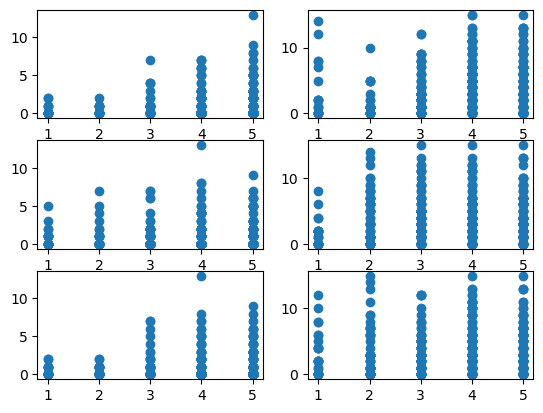

In [18]:
# Q1 = "Public health officials should have the power to order people into quarantine during COVID-19 outbreaks"
# Q2 = "If someone is given a quarantine order by a public health official, they should follow it no matter what else is going on in their life at work or home"
# Q3 = "If I go into quarantine, my family, friends, and community will be protected from getting COVID-19"

fig, axs = plt.subplots(3, 2)
axs[0, 0].scatter(q1_scores, qCounts)
axs[0, 1].scatter(q1_scores, noqCounts)
axs[1, 0].scatter(q2_scores, qCounts)
axs[1, 1].scatter(q2_scores, noqCounts)
axs[2, 0].scatter(q3_scores, qCounts)
axs[2, 1].scatter(q3_scores, noqCounts)

In [35]:
# sns.violinplot(x=q1_scores, y=qCounts, bw_adjust=.5, inner="stick")
sns.boxplot(x=q1_scores, y=qCounts)
if save_images:
    img_fn = "q1_vs_quarantine_yes." + image_format
    plt.savefig(os.path.join(output_folder, img_fn))
    plt.close('all')

In [36]:
# sns.violinplot(x=q1_scores, y=noqCounts, bw_adjust=.5, inner="stick")
sns.boxplot(x=q1_scores, y=noqCounts)
if save_images:
    img_fn = "q1_vs_quarantine_no." + image_format
    plt.savefig(os.path.join(output_folder, img_fn))
    plt.close('all')

In [37]:
# sns.violinplot(x=q2_scores, y=qCounts, bw_adjust=.5, inner="stick")
sns.boxplot(x=q2_scores, y=qCounts)
if save_images:
    img_fn = "q2_vs_quarantine_yes." + image_format
    plt.savefig(os.path.join(output_folder, img_fn))
    plt.close('all')

In [38]:
# sns.violinplot(x=q2_scores, y=noqCounts, bw_adjust=.5, inner="stick")
sns.boxplot(x=q2_scores, y=noqCounts)
if save_images:
    img_fn = "q2_vs_quarantine_no." + image_format
    plt.savefig(os.path.join(output_folder, img_fn))
    plt.close('all')

In [39]:
# sns.violinplot(x=q3_scores, y=qCounts, bw_adjust=.5, inner="stick")
sns.boxplot(x=q3_scores, y=qCounts)
if save_images:
    img_fn = "q3_vs_quarantine_yes." + image_format
    plt.savefig(os.path.join(output_folder, img_fn))
    plt.close('all')

In [40]:
# sns.violinplot(x=q3_scores, y=noqCounts, bw_adjust=.5, inner="stick")
sns.boxplot(x=q3_scores, y=noqCounts)
if save_images:
    img_fn = "q3_vs_quarantine_no." + image_format
    plt.savefig(os.path.join(output_folder, img_fn))
    plt.close('all')

In [41]:
sns.boxplot(x=q1_scores, y=q2_scores)
if save_images:
    img_fn = "q1_vs_q2." + image_format
    plt.savefig(os.path.join(output_folder, img_fn))
    plt.close('all')

In [42]:
sns.boxplot(x=q1_scores, y=q3_scores)
if save_images:
    img_fn = "q1_vs_q3." + image_format
    plt.savefig(os.path.join(output_folder, img_fn))
    plt.close('all')

In [43]:
sns.boxplot(x=q2_scores, y=q3_scores)
if save_images:
    img_fn = "q2_vs_q3." + image_format
    plt.savefig(os.path.join(output_folder, img_fn))
    plt.close('all')

## CORRELATION BETWEEN MESSAGING AND QUARANTINE CHOICE

In [44]:
# First PSA message: Thursday, November 23, 2023 6:08:13 PM (Shanghai time)
# timestamp: 1700784493

# End of first week: Friday 11/25 9 PM (Shanghai time)
# timestap: 1700917200

# Start of second week: Monday 11/27 9 AM (Shanghai time)
# timestamp: 1701046800

# Second PSA message: Tuesday, November 28, 2023 10:38:45 PM (Shanghai time)
# timestamp: 1701232725

# End of second week: Thursday 11/30 9 PM (Shanghai time)
# timestap: 1701349200

def calculate_counts_before_after(events, timestamp):
    q1_events = events[(events["type"] == "modifier") & (events["modifier"] == "https://www.wkuoo23-simulation.info/psa-message-1")]
    q2_events = events[(events["type"] == "modifier") & (events["modifier"] == "https://www.wkuoo23-simulation.info/psa-message-2")]    
    q1_users = list(q1_events["user_id"])
    q2_users = list(q2_events["user_id"])

    q1_before_counts = []
    q2_before_counts = []
    before_msg_events = events[events["time"] < timestamp]
    for id in q1_users:    
        qCount = len(before_msg_events[(before_msg_events["user_id"] == id) & (before_msg_events["type"] == "score") & (before_msg_events["inf"] == "quarantine")])
        q1_before_counts.append(qCount)
    for id in q2_users:  
        qCount = len(before_msg_events[(before_msg_events["user_id"] == id) & (before_msg_events["type"] == "score") & (before_msg_events["inf"] == "quarantine")])
        q2_before_counts.append(qCount)    

    q1_after_counts = []
    q2_after_counts = []
    after_msg_events = events[timestamp < events["time"]]
    for id in q1_users:
        qCount = len(after_msg_events[(after_msg_events["user_id"] == id) & (after_msg_events["type"] == "score") & (after_msg_events["inf"] == "quarantine")])
        q1_after_counts.append(qCount)
    for id in q2_users:
        qCount = len(after_msg_events[(after_msg_events["user_id"] == id) & (after_msg_events["type"] == "score") & (after_msg_events["inf"] == "quarantine")])
        q2_after_counts.append(qCount)
    
    return {"before_m1": q1_before_counts, "after_m1": q1_after_counts, "before_m2": q2_before_counts, "after_m2": q2_after_counts}
    

week1_events = events[(events["time"] < 1700917200)]
week2_events = events[(1701046800 < events["time"]) & (events["time"] < 1701349200)]

res_week1 = calculate_counts_before_after(week1_events, 1700784493)
res_week2 = calculate_counts_before_after(week2_events, 1701232725)


# before_msg1 = res_week1["before_m1"] + res_week2["before_m1"]
# after_msg1 = res_week1["after_m1"] + res_week2["after_m1"]

# before_msg2 = res_week1["before_m2"] + res_week2["before_m2"]
# after_msg2 = res_week1["after_m2"] + res_week2["after_m2"]

before_msg1 = res_week1["before_m1"]
after_msg1 = res_week1["after_m1"]

before_msg2 = res_week1["before_m2"]
after_msg2 = res_week1["after_m2"]

# before_msg1 = res_week2["before_m1"]
# after_msg1 = res_week2["after_m1"]

# before_msg2 = res_week2["before_m2"]
# after_msg2 = res_week2["after_m2"]

dict_msg1 = {'quarantine': before_msg1 + after_msg1, 'message': ["before"] * len(before_msg1) + ["after"] * len(after_msg1)} 
df_msg1 = pd.DataFrame(dict_msg1)

dict_msg2 = {'quarantine': before_msg2 + after_msg2, 'message': ["before"] * len(before_msg2) + ["after"] * len(after_msg2)} 
df_msg2 = pd.DataFrame(dict_msg2)

In [49]:
sns.violinplot(data=df_msg1, x="quarantine", y="message")
# sns.boxplot(data=df_msg1, x="quarantine", y="message")
if save_images:
    img_fn = "quarantine_before_vs_after_message1." + image_format
    plt.savefig(os.path.join(output_folder, img_fn))
    plt.close('all')

In [50]:
sns.violinplot(data=df_msg2, x="quarantine", y="message")
# sns.boxplot(data=df_msg2, x="quarantine", y="message")
if save_images:
    img_fn = "quarantine_before_vs_after_message2." + image_format
    plt.savefig(os.path.join(output_folder, img_fn))
    plt.close('all')

In [51]:
mean_before1 = df_msg1[df_msg1["message"] == "before"]["quarantine"].mean()
mean_after1 = df_msg1[df_msg1["message"] == "after"]["quarantine"].mean()
print(mean_before1)
print(mean_after1)
print(mean_after1/mean_before1)

0.75
0.375
0.5


In [52]:
mean_before2 = df_msg2[df_msg2["message"] == "before"]["quarantine"].mean()
mean_after2 = df_msg2[df_msg2["message"] == "after"]["quarantine"].mean()
print(mean_before2)
print(mean_after2)
print(mean_after2/mean_before2)

0.5
0.2777777777777778
0.5555555555555556
